In [576]:
import pandas as pd
import numpy as np
from scipy import stats
from wrangle import get_wrangle_bgs_data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train, validate, test = get_wrangle_bgs_data()
train.shape, validate.shape, test.shape

((1816, 14), (978, 14), (932, 14))

In [3]:
train.head()

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,0.0,1.0,dps,0.0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,1.0,0.0,dps,0.0
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1.0,0.0,heal,0.0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,1.0,0.0,dps,0.0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1.0,0.0,heal,0.0


# Exploration
### My goals for this project is to predict which faction will win based on its performance data.  

### My questions I want to explore are:
* Is there a difference between how often horde and alliance win?
    * Does it being a specific battleground change the odds of a faction winning?
* Are faction win rates different based on whether or not the game was during a bonus event?
* Does the number of healers on a team have an effect on the chances of a team winning?
* Do certain classes appear more than others on any given team?
    * If so is the ammount of that class on a team correlated with the faction being more likely to win?
* Do teams win more when everyone is doing good on average or if they have a carry out performing everyone else?

### Is there a difference between how often horde and alliance win?

In [4]:
game_list = list(train.code.value_counts().sort_index().index)
game_list

['ab1',
 'ab2',
 'ab3',
 'ab4',
 'ab5',
 'ab6',
 'ab7',
 'ab8',
 'ab9',
 'ab_10',
 'ab_11',
 'bg1',
 'bg2',
 'bg3',
 'bg4',
 'bg5',
 'bg6',
 'bg7',
 'bg8',
 'bg9',
 'bg_10',
 'bg_11',
 'bg_12',
 'bg_13',
 'bg_14',
 'bg_15',
 'bg_16',
 'bg_17',
 'bg_18',
 'bg_19',
 'bg_20',
 'bg_21',
 'bg_22',
 'bg_23',
 'bg_24',
 'bg_25',
 'bg_26',
 'bg_27',
 'bg_28',
 'bg_29',
 'bg_30',
 'bg_31',
 'bg_32',
 'bg_33',
 'bg_34',
 'dg2',
 'dg3',
 'dg4',
 'es1',
 'es2',
 'es3',
 'es4',
 'es5',
 'es6',
 'es7',
 'es8',
 'es9',
 'es_10',
 'es_11',
 'es_12',
 'es_13',
 'es_14',
 'es_15',
 'sa1',
 'sa2',
 'sa3',
 'sa4',
 'sm1',
 'sm2',
 'sm3',
 'sm4',
 'sm5',
 'sm6',
 'sm7',
 'sm8',
 'sm9',
 'sm_10',
 'sm_11',
 'sm_12',
 'sm_13',
 'sm_14',
 'sm_15',
 'sm_16',
 'sm_17',
 'sm_18',
 'sm_19',
 'sm_20',
 'sm_21',
 'sm_22',
 'sm_23',
 'sm_24',
 'sm_25',
 'sm_26',
 'sm_27',
 'tk1',
 'tk2',
 'tk3',
 'tk4',
 'tk5',
 'tk6',
 'tk7',
 'tk8',
 'tk9',
 'tk_10',
 'tk_11',
 'tk_12',
 'tk_13',
 'tk_14',
 'tk_15',
 'tk_16',
 'tk

In [5]:
horde = 0
alliance = 0
for game in game_list:
    if str(train[train.code == game][0:1].faction.values[0]) == 'alliance':
        if int(train[train.code == game][0:1].win.values[0]) == 1:
            alliance+=1
        else:
            horde+=1
    else:
        if int(train[train.code == game][0:1].win.values[0]) == 1:
            horde+=1
        else:
            alliance+=1
print(horde)
print(alliance)

112
61


In [6]:
faction_wins = pd.DataFrame({'faction': ['horde', 'alliance'], 'wins': [horde, alliance]},)
faction_wins

,faction,wins
0,horde,112
1,alliance,61


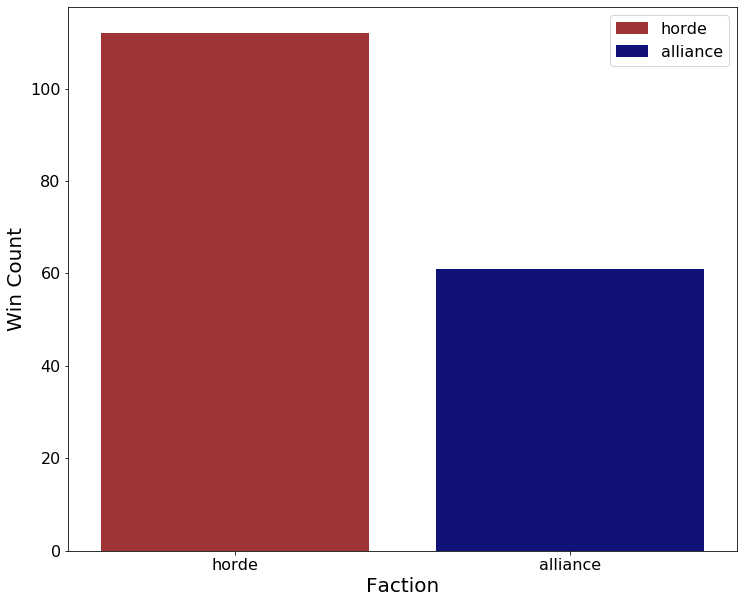

In [212]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x='faction', y='wins', hue='faction', data=faction_wins, ax=ax, dodge=False, palette=['firebrick', 'darkblue'])
plt.xlabel('Faction', fontsize=20)
plt.ylabel('Win Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

### Takeaways: 
Horde tends to win more often than alliance by a rather large margin.

### Does it being a specific battleground change the odds of a faction winning?

In [8]:
bg_list = list(train.battleground.value_counts().sort_index().index)
bg_list

['ab', 'bg', 'dg', 'es', 'sa', 'sm', 'tk', 'tp', 'wg']

In [35]:
alliance_wins = []
horde_wins = []
ally_win_percentage = []
horde_win_percentage = []
i = 0
for bg in bg_list:
    horde = 0
    alliance = 0
    
    for game in game_list:
        if bg == str(game)[0:2]:
            if str(train[train.code.str.contains(game)][0:1].faction.values[0]) == 'alliance':
                if int(train[train.code.str.contains(game)][0:1].win.values[0]) == 1:
                    alliance+=1
                else:
                    horde+=1
            else:
                if int(train[train.code.str.contains(game)][0:1].win.values[0]) == 1:
                    horde+=1
                else:
                    alliance+=1
        
    alliance_wins.append(alliance)
    horde_wins.append(horde)
    ally_win_percentage.append(alliance / (alliance + horde))
    horde_win_percentage.append(horde / (alliance + horde))

In [14]:
alliance_wins, horde_wins

([2, 10, 1, 3, 1, 7, 8, 12, 17], [9, 24, 2, 12, 3, 20, 17, 7, 18])

In [42]:
bg_faction_wins = (
    pd.DataFrame(
        list(
            zip(bg_list, alliance_wins, horde_wins, ally_win_percentage, horde_win_percentage)),
        columns=['battleground', 'alliance', 'horde', 'ally_percent', 'horde_percent']))

In [43]:
bg_faction_wins

,battleground,alliance,horde,ally_percent,horde_percent
0,ab,2,9,0.181818,0.818182
1,bg,10,24,0.294118,0.705882
2,dg,1,2,0.333333,0.666667
3,es,3,12,0.200000,0.800000
4,sa,1,3,0.250000,0.750000
5,sm,7,20,0.259259,0.740741
6,tk,8,17,0.320000,0.680000
7,tp,12,7,0.631579,0.368421
8,wg,17,18,0.485714,0.514286


In [60]:
tidy = bg_faction_wins[['battleground', 'alliance', 'horde']].melt(id_vars='battleground').rename(columns=str.title)
tidy.columns = tidy.columns.str.lower()

In [65]:
tidy

,battleground,variable,value
0,ab,alliance,2
1,bg,alliance,10
2,dg,alliance,1
3,es,alliance,3
4,sa,alliance,1
5,sm,alliance,7
6,tk,alliance,8
7,tp,alliance,12
8,wg,alliance,17
9,ab,horde,9


(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 7 Text yticklabel objects>)

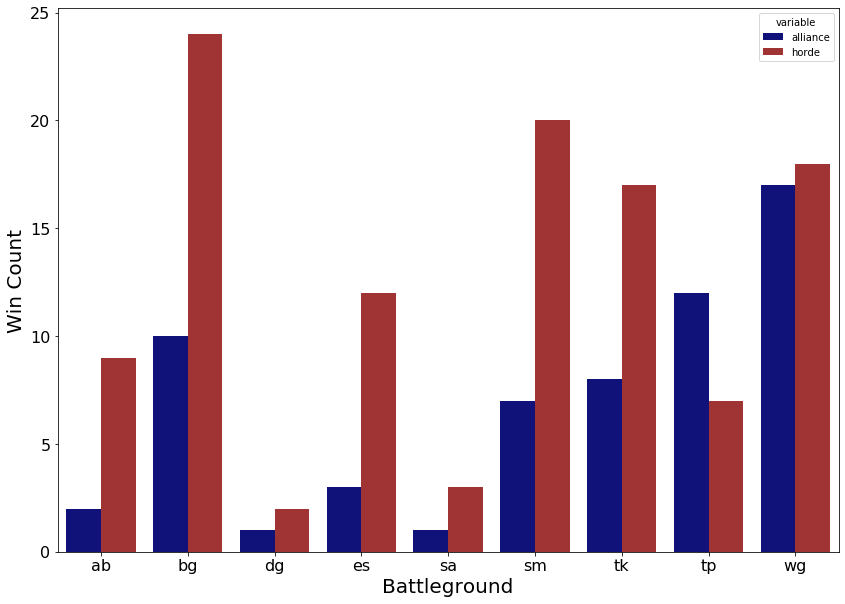

In [211]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x='battleground', y='value', data=tidy, hue='variable', ax=ax, palette=['darkblue', 'firebrick'])
plt.xlabel('Battleground', fontsize=20)
plt.ylabel('Win Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Takeaways:
**Horde** Best BGs:  
1. **Eye of the Storm (es):** 82% winrate
2. **Arathi Basin (ab): 77%** winrate
3. **Silvershard Mines (sm):** 75% winrate

**Alliance** Best BGs:
1. **Twin Peaks (tp):** 64% winrate
2. **Warsong Gulch (wg):** 50% winrate
3. **Strand of the Ancients (sa):** 43% winrate  

The alliance has a positive winrate in only one battleground and that is Twin Peaks.  
The only other battleground that isn't a negative winrate is Warsong Gulch which is sitting at a dead even 50% winrate.

### Are faction win rates different based on whether or not the game was during a bonus event?

In [68]:
bonus_events = train[train.be == 1]
bonus_events

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be
147,wg,wg8,horde,mage,7,2,20,74679,11349,671,1.0,0.0,dps,1.0
2234,wg,wg_27,horde,druid,1,4,10,10081,5321,206,0.0,1.0,dps,1.0
2426,tp,tp_13,alliance,mage,2,2,9,29025,12012,262,0.0,1.0,dps,1.0
503,bg,bg9,alliance,mage,8,3,39,96730,7997,1054,1.0,0.0,dps,1.0
1028,sm,sm6,alliance,demon hunter,5,0,45,97774,9828,1038,1.0,0.0,dps,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,bg,bg_24,horde,shaman,8,5,25,53416,6494,678,1.0,0.0,dps,1.0
2217,wg,wg_27,alliance,rogue,1,3,33,14963,11604,735,1.0,0.0,dps,1.0
2417,sm,sm_17,horde,rogue,1,1,11,53876,6076,353,1.0,0.0,dps,1.0
1042,sm,sm6,horde,death knight,3,5,14,61492,38798,267,0.0,1.0,dps,1.0


In [80]:
be_list = list(bonus_events.battleground.value_counts().sort_index().index)
be_games = list(bonus_events.code.value_counts().sort_index().index)
be_list, be_games

(['ab', 'bg', 'es', 'sa', 'sm', 'tp', 'wg'],
 ['ab5',
  'bg8',
  'bg9',
  'bg_24',
  'bg_31',
  'es1',
  'es2',
  'es5',
  'es6',
  'sa2',
  'sm5',
  'sm6',
  'sm_16',
  'sm_17',
  'tp_11',
  'tp_12',
  'tp_13',
  'tp_14',
  'wg4',
  'wg7',
  'wg8',
  'wg_27',
  'wg_28',
  'wg_29'])

In [81]:
allies_be = []
horde_be = []
ally_be_percentage = []
horde_be_percentage = []
i = 0
for bg in be_list:
    horde = 0
    alliance = 0
    
    for game in be_games:
        if bg == str(game)[0:2]:
            if str(bonus_events[bonus_events.code.str.contains(game)][0:1].faction.values[0]) == 'alliance':
                if int(bonus_events[bonus_events.code.str.contains(game)][0:1].win.values[0]) == 1:
                    alliance+=1
                else:
                    horde+=1
            else:
                if int(bonus_events[bonus_events.code.str.contains(game)][0:1].win.values[0]) == 1:
                    horde+=1
                else:
                    alliance+=1
        
    allies_be.append(alliance)
    horde_be.append(horde)
    ally_be_percentage.append(alliance / (alliance + horde))
    horde_be_percentage.append(horde / (alliance + horde))
    
be_faction_wins = (
    pd.DataFrame(
        list(
            zip(be_list, allies_be, horde_be, ally_be_percentage, horde_be_percentage)),
        columns=['battleground', 'alliance', 'horde', 'ally_percent', 'horde_percent']))

be_faction_wins

,battleground,alliance,horde,ally_percent,horde_percent
0,ab,0,1,0.000000,1.000000
1,bg,1,3,0.250000,0.750000
2,es,1,3,0.250000,0.750000
3,sa,0,1,0.000000,1.000000
4,sm,2,2,0.500000,0.500000
5,tp,2,2,0.500000,0.500000
6,wg,2,4,0.333333,0.666667


In [82]:
tidy_be = be_faction_wins[['battleground', 'alliance', 'horde']].melt(id_vars='battleground').rename(columns=str.title)
tidy_be.columns = tidy_be.columns.str.lower()

In [83]:
tidy_be

,battleground,variable,value
0,ab,alliance,0
1,bg,alliance,1
2,es,alliance,1
3,sa,alliance,0
4,sm,alliance,2
5,tp,alliance,2
6,wg,alliance,2
7,ab,horde,1
8,bg,horde,3
9,es,horde,3


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 10 Text yticklabel objects>)

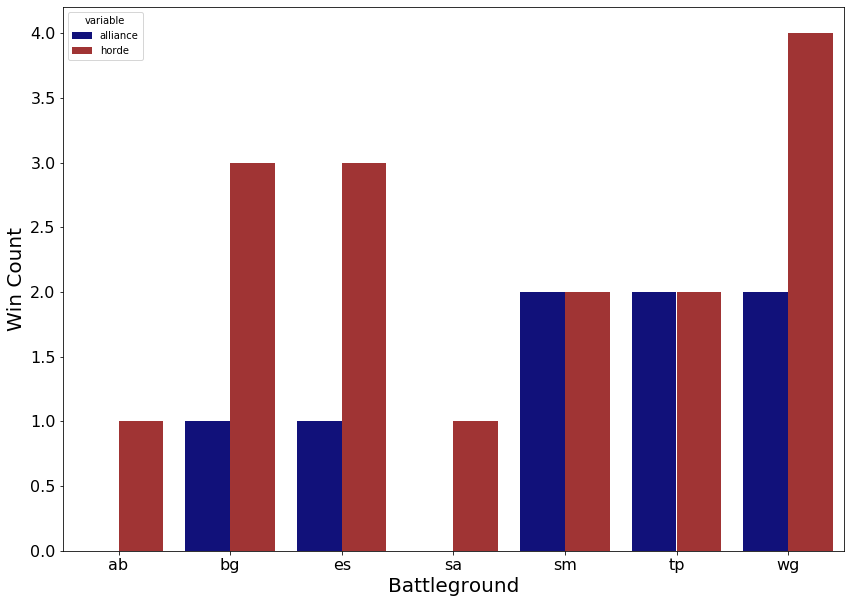

In [276]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x='battleground', y='value', hue='variable', data=tidy_be, ax=ax, palette=['darkblue', 'firebrick'])
plt.xlabel('Battleground', fontsize=20)
plt.ylabel('Win Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Takeaways:
Ignoring the battlegrounds with only one game of data:  

**Horde** Best BGs:  
1. **Battle for Guilneas (bg):** 75% winrate
2. **Silvershard Mines(sm):** 75% winrate
3. **Warsong Gulch (wg):** 66% winrate

**Alliance** Best BGs:
1. **Twin Peaks (tp):** 50% winrate
2. **Silvershard Mines (sm):** 50% winrate
3. **Warsong Gulch (wg):** 33% winrate  

When it comes to bonus events horde doesn't have any negative winrates, horde consistently beats or ties alliance in a faction breakdown by battleground.

### Does the number of healers on a team have an effect on the chances of a team winning?

In [111]:
train

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,0.0,1.0,dps,0.0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,1.0,0.0,dps,0.0
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1.0,0.0,heal,0.0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,1.0,0.0,dps,0.0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1.0,0.0,heal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,1.0,0.0,dps,0.0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,1.0,0.0,heal,0.0
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,1.0,0.0,dps,0.0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,1.0,0.0,dps,1.0


In [669]:
train['is_heal'] = [1 if rol == 'heal' else 0 for rol in train.rol]
validate['is_heal'] = [1 if rol == 'heal' else 0 for rol in validate.rol]
test['is_heal'] = [1 if rol == 'heal' else 0 for rol in test.rol]

In [563]:
train.groupby('faction').is_heal.sum()

faction
alliance    161
horde       193
Name: is_heal, dtype: int64

In [166]:
train.groupby(['code', 'faction']).agg({'is_heal': 'sum'}).sort_values(by=['is_heal', 'code'], ascending=False).head(20)

,,is_heal
code,faction,
es_13,alliance,4
es7,horde,4
wg_33,horde,3
wg_30,horde,3
wg_14,alliance,3
wg_10,horde,3
tk_23,horde,3
tk7,alliance,3
es_10,horde,3


In [168]:
# This is an eye of the storm map which is statistically most likely a horde victory.
# Lets see if the alliance having more healers scored them a win.
train[train.code == 'es_13'].groupby('faction').is_heal.sum()

faction
alliance    4
horde       1
Name: is_heal, dtype: int64

In [174]:
# Nope horde still won this battleground.
train[train.code == 'es_13'].head()

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
3133,es,es_13,alliance,death knight,1,3,9,57050,13802,181,0.0,1.0,dps,0.0,0
3130,es,es_13,alliance,warrior,3,6,8,36268,4875,175,0.0,1.0,dps,0.0,0
3115,es,es_13,horde,hunter,2,1,41,53289,4734,396,1.0,0.0,dps,0.0,0
3112,es,es_13,horde,death knight,5,1,41,63125,10425,549,1.0,0.0,dps,0.0,0
3122,es,es_13,alliance,priest,0,4,7,428,60033,171,0.0,1.0,heal,0.0,1


In [172]:
train[train.code == 'es7'].groupby('faction').is_heal.sum()

faction
alliance    2
horde       4
Name: is_heal, dtype: int64

In [175]:
train[train.code == 'es7'].head()

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
2363,es,es7,horde,rogue,3,1,41,37217,3241,635,1.0,0.0,dps,0.0,0
2355,es,es7,alliance,hunter,1,5,11,33393,0,120,0.0,1.0,dps,0.0,0
2361,es,es7,alliance,warlock,2,3,12,37793,9550,234,0.0,1.0,dps,0.0,0
2373,es,es7,horde,druid,1,1,36,46841,116435,627,1.0,0.0,heal,0.0,1
2354,es,es7,alliance,demon hunter,2,3,6,70538,7862,219,0.0,1.0,dps,0.0,0


In [176]:
# Warsong Gulch is more of a toss-up, roughly 50/50 for odds
# Did the horde score a win with the higher number of healers?
train[train.code == 'wg_33'].groupby('faction').is_heal.sum()

faction
alliance    2
horde       3
Name: is_heal, dtype: int64

In [178]:
# Yes they did, now lets try one where the alliance healers outnumber the horde.
train[train.code == 'wg_33'].head()

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
3666,wg,wg_33,horde,monk,0,2,8,11602,141000,486,1.0,0.0,heal,0.0,1
3671,wg,wg_33,horde,shaman,2,5,8,27921,128000,337,1.0,0.0,heal,0.0,1
3676,wg,wg_33,alliance,paladin,1,0,13,6973,86937,191,0.0,1.0,heal,0.0,1
3681,wg,wg_33,alliance,mage,2,4,14,80581,27412,319,0.0,1.0,dps,0.0,0
3679,wg,wg_33,alliance,mage,8,0,24,124000,22516,339,0.0,1.0,dps,0.0,0


In [179]:
# This is also a warsong gulch and the horde team has no healers, lets see if the alliance pulled out a win
train[train.code == 'wg_14'].groupby('faction').is_heal.sum()

faction
alliance    3
horde       0
Name: is_heal, dtype: int64

In [181]:
# They actually did win this one, could these be correlated?
train[train.code == 'wg_14'].head()

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
264,wg,wg_14,horde,mage,2,4,21,29112,7219,168,0.0,1.0,dps,0.0,0
265,wg,wg_14,alliance,monk,1,4,33,14806,54073,313,1.0,0.0,heal,0.0,1
274,wg,wg_14,horde,warrior,3,7,23,20776,9371,171,0.0,1.0,dps,0.0,0
260,wg,wg_14,alliance,druid,0,4,45,778,34434,487,1.0,0.0,heal,0.0,1
267,wg,wg_14,horde,warrior,2,4,14,7757,6224,153,0.0,1.0,dps,0.0,0


### Takeaways:  
At the very least when it comes to the more competitive battlegrounds having more healers may give you an edge, this needs to be looked at further in hypothesis testing.

### Do certain classes appear more than others on any given team?

In [220]:
train

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,0.0,1.0,dps,0.0,0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,1.0,0.0,dps,0.0,0
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1.0,0.0,heal,0.0,1
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,1.0,0.0,dps,0.0,0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1.0,0.0,heal,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,1.0,0.0,dps,0.0,0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,1.0,0.0,heal,0.0,1
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,1.0,0.0,dps,0.0,0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,1.0,0.0,dps,1.0,0


In [321]:
train.c_class.value_counts()

warrior         190
shaman          189
druid           186
mage            168
hunter          164
paladin         153
rogue           146
warlock         144
priest          139
demon hunter    132
death knight    120
monk             85
Name: c_class, dtype: int64

In [233]:
faction_classes = pd.DataFrame(train.groupby('faction').c_class.value_counts())
faction_classes.columns = ['class_count']
faction_classes.reset_index(inplace=True)
faction_classes

,faction,c_class,class_count
0,alliance,druid,113
1,alliance,mage,96
2,alliance,warrior,94
3,alliance,hunter,87
4,alliance,paladin,85
5,alliance,rogue,73
6,alliance,priest,70
7,alliance,warlock,67
8,alliance,demon hunter,66
9,alliance,death knight,59


In [288]:
faction_classes = faction_classes.sort_values(by='class_count', ascending=False)
faction_classes.head()

,faction,c_class,class_count
12,horde,shaman,133
0,alliance,druid,113
13,horde,warrior,96
1,alliance,mage,96
2,alliance,warrior,94


In [328]:
allies_classes = (pd.DataFrame(faction_classes[faction_classes.faction == 'alliance']
                    .class_count / faction_classes[faction_classes.faction == 'alliance'].class_count.sum()))

horde_classes = (pd.DataFrame(faction_classes[faction_classes.faction == 'horde']
                    .class_count / faction_classes[faction_classes.faction == 'horde'].class_count.sum()))

allies_classes.columns = ['faction_percentage']
horde_classes.columns = ['faction_percentage']

combi_classes = pd.concat([allies_classes, horde_classes])

faction_classes['faction_percentage'] = combi_classes

In [331]:
faction_classes

,faction,c_class,class_count,faction_percentage
12,horde,shaman,133,0.147124
0,alliance,druid,113,0.123904
13,horde,warrior,96,0.106195
1,alliance,mage,96,0.105263
2,alliance,warrior,94,0.103070
3,alliance,hunter,87,0.095395
4,alliance,paladin,85,0.093202
14,horde,hunter,77,0.085177
15,horde,warlock,77,0.085177
17,horde,rogue,73,0.080752


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text yticklabel objects>)

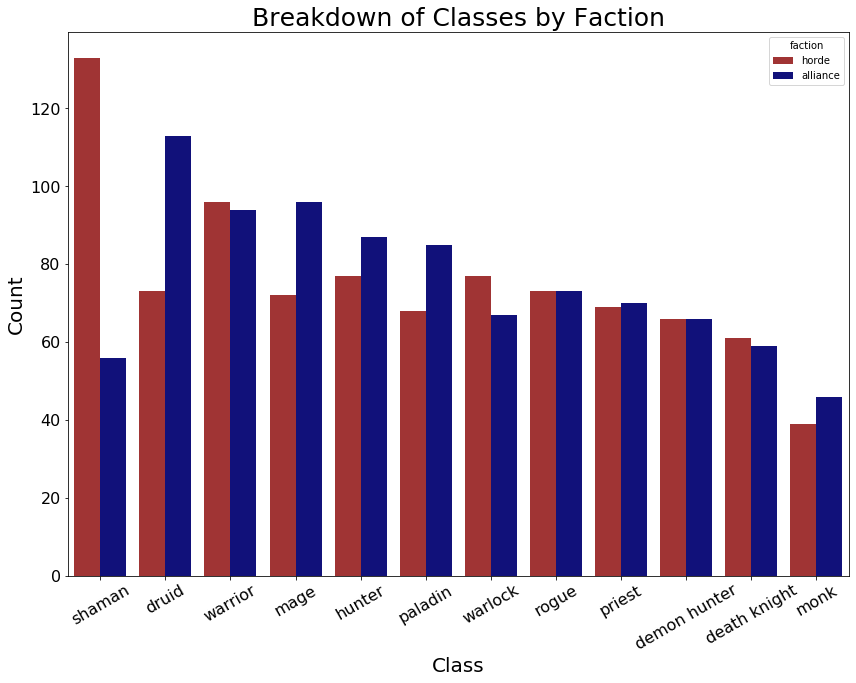

In [290]:
fig, ax = plt.subplots(figsize=(14,10))
g = sns.barplot(x='c_class', y='class_count', data=faction_classes, hue='faction', ax=ax, palette=['firebrick', 'darkblue'])
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Breakdown of Classes by Faction', fontsize=25)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)

In [248]:
losing_classes = pd.DataFrame(train[train.win == 0].groupby('faction').c_class.value_counts())
losing_classes.columns = ['class_count']
losing_classes.reset_index(inplace=True)
losing_classes

,faction,c_class,class_count
0,alliance,druid,72
1,alliance,hunter,66
2,alliance,warrior,63
3,alliance,mage,62
4,alliance,paladin,56
5,alliance,priest,49
6,alliance,warlock,49
7,alliance,demon hunter,46
8,alliance,rogue,44
9,alliance,shaman,38


In [285]:
losing_classes = losing_classes.sort_values(by='class_count', ascending=False)
losing_classes.head()

,faction,c_class,class_count
0,alliance,druid,72
1,alliance,hunter,66
2,alliance,warrior,63
3,alliance,mage,62
4,alliance,paladin,56


(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 9 Text yticklabel objects>)

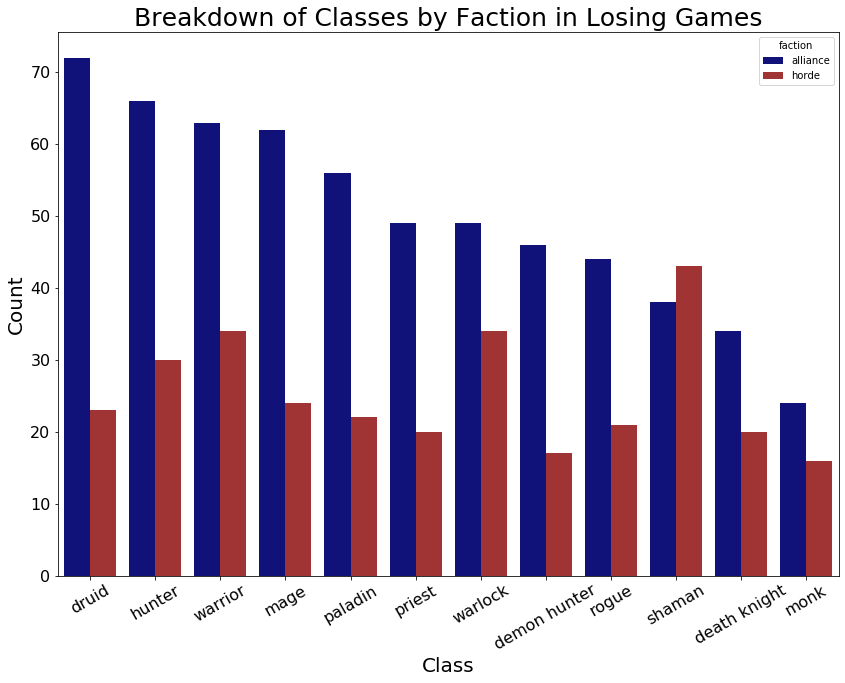

In [286]:
fig, ax = plt.subplots(figsize=(14,10))
g = sns.barplot(x='c_class', y='class_count', data=losing_classes, hue='faction', ax=ax, palette=['darkblue', 'firebrick'])
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Breakdown of Classes by Faction in Losing Games', fontsize=25)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)

In [243]:
winning_classes = pd.DataFrame(train[train.win == 1].groupby('faction').c_class.value_counts())
winning_classes.columns = ['class_count']
winning_classes.reset_index(inplace=True)
winning_classes

,faction,c_class,class_count
0,alliance,druid,41
1,alliance,mage,34
2,alliance,warrior,31
3,alliance,paladin,29
4,alliance,rogue,29
5,alliance,death knight,25
6,alliance,monk,22
7,alliance,hunter,21
8,alliance,priest,21
9,alliance,demon hunter,20


In [287]:
winning_classes = winning_classes.sort_values(by='class_count', ascending=False)
winning_classes.head()

,faction,c_class,class_count
12,horde,shaman,90
13,horde,warrior,62
14,horde,rogue,52
15,horde,druid,50
17,horde,priest,49


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text yticklabel objects>)

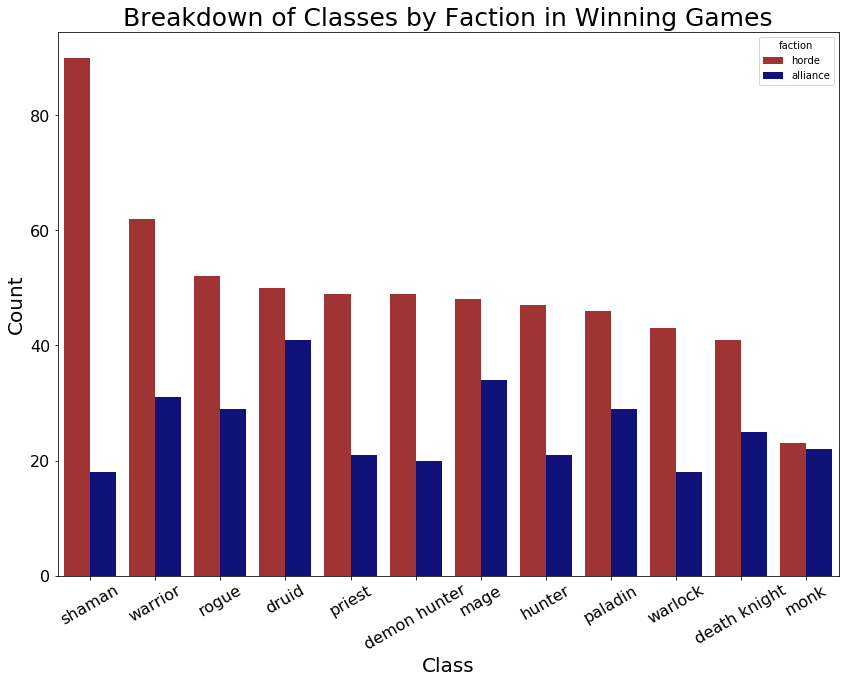

In [284]:
fig, ax = plt.subplots(figsize=(14,10))
g = sns.barplot(x='c_class', y='class_count', data=winning_classes, hue='faction', ax=ax, palette=['firebrick', 'darkblue'])
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Breakdown of Classes by Faction in Winning Games', fontsize=25)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)

There seem to be a lot of shamans in the games that horde won. I want to see what the average number of horde shamans are in a game to see if they are stacking them or just taking one or two.

In [268]:
# Here is the dataframe with just the horde shamans that won games
train[(train.c_class == 'shaman') & (train.win == 1) & (train.faction == 'horde')]

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1.0,0.0,heal,0.0,1
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1.0,0.0,heal,0.0,1
3309,tk,tk_24,horde,shaman,5,1,25,42286,2712,503,1.0,0.0,dps,0.0,0
1424,wg,wg_18,horde,shaman,1,6,8,39354,18043,506,1.0,0.0,dps,0.0,0
3025,es,es_10,horde,shaman,1,2,32,9816,87543,670,1.0,0.0,heal,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,bg,bg_24,horde,shaman,8,5,25,53416,6494,678,1.0,0.0,dps,1.0,0
1778,ab,ab2,horde,shaman,1,4,39,9539,77324,563,1.0,0.0,heal,0.0,1
2853,bg,bg_29,horde,shaman,0,1,25,8958,60665,522,1.0,0.0,heal,0.0,1
2542,ab,ab7,horde,shaman,8,2,30,52754,2307,384,1.0,0.0,dps,0.0,0


In [273]:
# It seems the average won game comes out to roughly ~1.5 horde shamans
train[(train.c_class == 'shaman') & (train.win == 1) & (train.faction == 'horde')].code.value_counts().mean()

1.4285714285714286

In [269]:
# A small majority of these shamans were healers now we will look at a couple individual games
train[(train.c_class == 'shaman') & (train.win == 1) & (train.faction == 'horde')].is_heal.value_counts()

1    59
0    31
Name: is_heal, dtype: int64

In [275]:
train[(train.c_class == 'shaman') & (train.win == 1) & (train.faction == 'horde')].code.value_counts().head(10)

sm_26    4
es_14    3
sa1      3
ab2      3
ab8      3
sm_14    2
tp_12    2
sa3      2
ab_11    2
bg_30    2
Name: code, dtype: int64

In [274]:
train[train.code == 'sm_26']

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
3551,sm,sm_26,alliance,shaman,0,2,12,17566,12109,275,0.0,1.0,dps,0.0,0
3550,sm,sm_26,horde,shaman,4,0,35,78403,9634,528,1.0,0.0,dps,0.0,0
3560,sm,sm_26,alliance,warlock,3,6,15,45038,23964,284,0.0,1.0,dps,0.0,0
3558,sm,sm_26,horde,shaman,5,0,36,62710,13916,379,1.0,0.0,dps,0.0,0
3552,sm,sm_26,alliance,druid,0,1,13,417,49145,285,0.0,1.0,heal,0.0,1
3553,sm,sm_26,horde,shaman,0,2,36,9710,75893,529,1.0,0.0,heal,0.0,1
3556,sm,sm_26,horde,shaman,3,3,31,45926,10094,520,1.0,0.0,dps,0.0,0
3549,sm,sm_26,alliance,hunter,6,2,17,55144,10838,298,0.0,1.0,dps,0.0,0
3554,sm,sm_26,alliance,rogue,4,1,17,20908,17645,292,0.0,1.0,dps,0.0,0


Four horde shamans in this team but only 1 is a healer.

In [277]:
train[train.code == 'sa1']

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
1284,sa,sa1,alliance,druid,1,2,29,56692,43818,298,0.0,1.0,dps,0.0,0
1297,sa,sa1,horde,shaman,2,8,23,69811,18597,494,1.0,0.0,dps,0.0,0
1283,sa,sa1,horde,hunter,3,1,28,102000,7947,357,1.0,0.0,dps,0.0,0
1271,sa,sa1,alliance,warrior,1,1,29,31129,12358,291,0.0,1.0,dps,0.0,0
1282,sa,sa1,horde,druid,1,1,28,6112,127000,352,1.0,0.0,heal,0.0,1
1292,sa,sa1,horde,shaman,1,2,33,44022,12723,354,1.0,0.0,dps,0.0,0
1294,sa,sa1,horde,shaman,2,3,20,52338,23003,494,1.0,0.0,dps,0.0,0
1272,sa,sa1,alliance,warrior,2,6,33,57950,5784,305,0.0,1.0,dps,0.0,0
1285,sa,sa1,alliance,druid,6,1,40,100000,15722,314,0.0,1.0,dps,0.0,0
1287,sa,sa1,alliance,warrior,1,5,31,44539,27531,295,0.0,1.0,dps,0.0,0


Three horde shamans in this one and none of them are healers.

In [278]:
train[train.code == 'ab2']

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
1796,ab,ab2,alliance,warrior,8,1,37,40401,8881,303,0.0,1.0,dps,0.0,0
1791,ab,ab2,alliance,mage,11,3,48,148000,11004,447,0.0,1.0,dps,0.0,0
1781,ab,ab2,horde,demon hunter,3,1,31,49495,14693,382,1.0,0.0,dps,0.0,0
1787,ab,ab2,alliance,warrior,9,5,21,70882,11634,394,0.0,1.0,dps,0.0,0
1773,ab,ab2,alliance,rogue,1,0,5,3417,537,159,0.0,1.0,dps,0.0,0
1788,ab,ab2,alliance,shaman,5,4,52,52029,21458,451,0.0,1.0,dps,0.0,0
1783,ab,ab2,horde,rogue,1,2,6,15652,3278,144,1.0,0.0,dps,0.0,0
1800,ab,ab2,horde,monk,0,5,33,1147,74580,388,1.0,0.0,heal,0.0,1
1774,ab,ab2,alliance,paladin,0,5,22,10392,89132,389,0.0,1.0,heal,0.0,1
1786,ab,ab2,alliance,mage,5,5,33,56012,16984,409,0.0,1.0,dps,0.0,0


Two of the three horde shamans in this battle were healers.

In [279]:
train[train.code == 'ab8']

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1.0,0.0,heal,0.0,1
2583,ab,ab8,horde,rogue,4,3,29,57225,2269,547,1.0,0.0,dps,0.0,0
2585,ab,ab8,alliance,mage,12,0,28,72836,4575,209,0.0,1.0,dps,0.0,0
2591,ab,ab8,horde,rogue,1,1,13,45638,8349,493,1.0,0.0,dps,0.0,0
2573,ab,ab8,horde,shaman,13,1,46,152000,19158,418,1.0,0.0,dps,0.0,0
2587,ab,ab8,horde,warlock,4,3,28,65517,34603,527,1.0,0.0,dps,0.0,0
2566,ab,ab8,alliance,death knight,6,3,33,81815,18054,337,0.0,1.0,dps,0.0,0
2580,ab,ab8,horde,priest,0,3,37,11169,121000,549,1.0,0.0,heal,0.0,1
2574,ab,ab8,horde,shaman,0,5,21,18065,134000,357,1.0,0.0,heal,0.0,1
2590,ab,ab8,alliance,paladin,2,3,33,62039,26159,342,0.0,1.0,dps,0.0,0


Another two of the three horde shamans were healers.

In [334]:
# Now we shall take a look at which class has wins the most games on average.
print(f"General Class Winrates:\n{train.groupby('c_class').mean().win.sort_values(ascending=False)}")

General Class Winrates:
c_class
shaman          0.571429
rogue           0.554795
death knight    0.550000
monk            0.529412
demon hunter    0.522727
priest          0.503597
paladin         0.490196
warrior         0.489474
druid           0.489247
mage            0.488095
warlock         0.423611
hunter          0.414634
Name: win, dtype: float64


In [335]:
print(f"Alliance Class Winrates:\n{train[train.faction == 'alliance'].groupby('c_class').mean().win.sort_values(ascending=False)}")

Alliance Class Winrates:
c_class
monk            0.478261
death knight    0.423729
rogue           0.397260
druid           0.362832
mage            0.354167
paladin         0.341176
warrior         0.329787
shaman          0.321429
demon hunter    0.303030
priest          0.300000
warlock         0.268657
hunter          0.241379
Name: win, dtype: float64


In [336]:
print(f"Horde Class Winrates:\n{train[train.faction == 'horde'].groupby('c_class').mean().win.sort_values(ascending=False)}")

Horde Class Winrates:
c_class
demon hunter    0.742424
rogue           0.712329
priest          0.710145
druid           0.684932
shaman          0.676692
paladin         0.676471
death knight    0.672131
mage            0.666667
warrior         0.645833
hunter          0.610390
monk            0.589744
warlock         0.558442
Name: win, dtype: float64


It seems that shamans win the most games on average which makes sense seeing as the majority of shamans play horde, rogue comes up just behind it however at 55% which isn't bad considering they have an even split in faction populations.  

Hunters may be weak seeing as they have an abysmal 41% win rate while there is only slightly more alliance hunters than horde hunters.

### Takeaways:  
**Best Horde Classes:**  
1. Shaman (15% pickrate, 68% winrate)
2. Rogue (8% pickrate, 71% winrate)
3. Demon Hunter(7% pickrate, 71% winrate)

**Best Alliance Classes:**  
1. Monk (5% pickrate, 48% winrate)
2. Deathknight ( 6.5% pickrate, 42% winrate)
3. Rogue (8% pickrate, 39% winrate)  

Shamans as a class was played mostly by horde and was their highest played class.  
While it didn't have their best winrate it seems to be doing the best overall.  
Alliance hunters seem to be doing the worst and have an abysmal win rate.

# Hypothesis Testing

## Hypothesis Test 1

$H_0$: A team is not more likely to win if it is horde.  
$H_a$: A team is more likely to win if it is horde.  
alpha = .05  

We will be performing a Chi^2 test on this variable and our target variable.

In [344]:
observed = pd.crosstab(train.win, train.is_horde)
observed

is_horde,0,1
win,,
0,603,304
1,309,600


In [346]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi^2: {chi2}\tP Value: {p}')

Chi^2: 190.39729665041824	P Value: 2.6038156425019826e-43


The p value is lower than our alpha which means we can reject the null hypothesis that teams are not more likely to win if they are horde.

## Hypothesis Test 2

$H_0$: A horde team is not more likely to win if it is playing on Eye of the Storm (es)  
$H_a$: A team is more likely to win if it is horde and playing on Eye of the Storm (es)  
alpha = .05  

We will be performing a Chi^2 test on this variable and our target variable.

In [670]:
train['es_horde'] = np.where(((train['faction'] == 'horde') & (train['battleground'] == 'es')), 1, 0)
validate['es_horde'] = np.where(((validate['faction'] == 'horde') & (validate['battleground'] == 'es')), 1, 0)
test['es_horde'] = np.where(((test['faction'] == 'horde') & (test['battleground'] == 'es')), 1, 0)

train

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,...,rol,be,is_heal,is_horde,es_horde,has_healers,allies_has_hunters,horde_win,horde_has_healers,allies_has_healers
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,...,dps,0.0,0,0,0,0,0,1,0,0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,...,dps,0.0,0,1,0,1,1,1,0,1
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,...,heal,0.0,1,1,0,1,0,1,1,0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,...,dps,0.0,0,1,0,1,0,1,1,0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,...,heal,0.0,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,...,dps,0.0,0,1,0,0,0,1,0,0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,...,heal,0.0,1,1,0,0,0,1,0,0
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,...,dps,0.0,0,1,0,0,0,1,0,0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,...,dps,1.0,0,1,0,0,0,1,0,0


In [540]:
train['es_bg'] = np.where(((train['faction'] == 'horde') & (train['battleground'] == 'es')), 1, 0)
train

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal,is_horde,es_horde,has_healers,allies_has_hunters,es_bg
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,0,1.0,dps,0.0,0,0,0,0,0,0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,1,0.0,dps,0.0,0,1,0,1,1,0
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1,0.0,heal,0.0,1,1,0,1,0,0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,1,0.0,dps,0.0,0,1,0,1,0,0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1,0.0,heal,0.0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,1,0.0,dps,0.0,0,1,0,0,0,0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,1,0.0,heal,0.0,1,1,0,0,0,0
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,1,0.0,dps,0.0,0,1,0,0,0,0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,1,0.0,dps,1.0,0,1,0,0,0,0


In [541]:
observed = pd.crosstab(train.win, train.es_horde)
observed

es_horde,0,1
win,,
0,886,21
1,821,88


In [542]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi^2: {chi2}\tP Value: {p}')

Chi^2: 42.36068283032005	P Value: 7.590061803753245e-11


While not as strongly correlated our p value is still below our alpha and so we can reject the null hypothesis that a team is not more likely to win if they are horde and on eye of the storm.

## Hypothesis Test 3

$H_0$: A team is not more likely to win if they have 2 or more healers  
$H_a$: A team is more likely to win if they have 2 or more healers  
alpha = .05  

We will be performing a Chi^2 test on this variable and our target variable.

In [470]:
observed = pd.crosstab(train.win, train.has_healers)
observed

has_healers,0,1
win,,
0,465,442
1,472,437


In [471]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi^2: {chi2}\tP Value: {p}')

Chi^2: 0.054420416607856265	P Value: 0.8155425596532386


The p value is very high compared to the alpha and the crosstab is wildly inaccurate. This feature is not correlated.

### Work for creating feature below:

In [567]:
all_healers = pd.DataFrame(train.groupby(['code', 'faction']).sum().is_heal)
all_healers.reset_index(inplace=True)

horde_healers = pd.DataFrame(train[train.faction == 'horde'].groupby(['code', 'faction']).sum().is_heal)
horde_healers.reset_index(inplace=True)
allies_healers = pd.DataFrame(train[train.faction == 'alliance'].groupby(['code', 'faction']).sum().is_heal)
allies_healers.reset_index(inplace=True)

feature_healers = all_healers[all_healers.is_heal >= 2].sort_values(by='is_heal', ascending=False)
feature_horde_healers = horde_healers[horde_healers.is_heal >= 2].sort_values(by='is_heal', ascending=False)
feature_allies_healers = allies_healers[allies_healers.is_heal >= 2].sort_values(by='is_heal', ascending=False)
feature_healers

,code,faction,is_heal
109,es7,horde,4
120,es_13,alliance,4
294,wg_10,horde,3
334,wg_30,horde,3
115,es_10,horde,3
...,...,...,...
119,es_12,horde,2
117,es_11,horde,2
111,es8,horde,2
108,es7,alliance,2


In [568]:
list_healers = list(feature_healers.code)
list_horde_healers = list(feature_horde_healers.code)
list_allies_healers = list(feature_allies_healers.code)

list_healers

['es7',
 'es_13',
 'wg_10',
 'wg_30',
 'es_10',
 'es5',
 'dg2',
 'tk_23',
 'bg_10',
 'wg_14',
 'tk7',
 'es8',
 'ab_11',
 'ab2',
 'ab8',
 'ab3',
 'wg_33',
 'tk5',
 'tp4',
 'tp8',
 'tp7',
 'tk1',
 'tk1',
 'tp3',
 'tk4',
 'tk_24',
 'tk2',
 'tk_15',
 'tk_13',
 'tp9',
 'ab1',
 'wg1',
 'tp9',
 'wg_10',
 'wg_33',
 'wg_32',
 'wg_32',
 'wg_31',
 'wg_26',
 'wg_15',
 'wg9',
 'tp_17',
 'wg7',
 'wg4',
 'wg4',
 'wg3',
 'sm_19',
 'tp_18',
 'sm_23',
 'sm3',
 'sm_15',
 'es4',
 'es2',
 'bg_34',
 'bg_29',
 'bg_29',
 'bg_24',
 'bg8',
 'bg8',
 'bg7',
 'bg5',
 'bg2',
 'bg1',
 'ab5',
 'ab4',
 'ab4',
 'ab3',
 'es3',
 'es4',
 'sm_14',
 'es6',
 'sm_11',
 'sm8',
 'sm7',
 'ab1',
 'sm2',
 'sm1',
 'sa4',
 'sa4',
 'sa3',
 'sa1',
 'es_15',
 'es_12',
 'es_11',
 'es8',
 'es7',
 'wg_34']

In [569]:
train['has_healers'] = 0
for row in train.index:
    if train.code[row] in list_healers:
        train['has_healers'][row] = 1
    else:
        train['has_healers'][row] = 0

train['horde_has_healers'] = 0
for row in train.index:
    if train.code[row] in list_horde_healers:
        train['horde_has_healers'][row] = 1
    else:
        train['horde_has_healers'][row] = 0

train['allies_has_healers'] = 0
for row in train.index:
    if train.code[row] in list_allies_healers:
        train['allies_has_healers'][row] = 1
    else:
        train['allies_has_healers'][row] = 0

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/anaconda3/li

In [570]:
train

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,...,rol,be,is_heal,is_horde,es_horde,has_healers,allies_has_hunters,horde_win,horde_has_healers,allies_has_healers
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,...,dps,0.0,0,0,0,0,0,1,0,0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,...,dps,0.0,0,1,0,1,1,1,0,1
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,...,heal,0.0,1,1,0,1,0,1,1,0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,...,dps,0.0,0,1,0,1,0,1,1,0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,...,heal,0.0,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,...,dps,0.0,0,1,0,0,0,1,0,0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,...,heal,0.0,1,1,0,0,0,1,0,0
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,...,dps,0.0,0,1,0,0,0,1,0,0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,...,dps,1.0,0,1,0,0,0,1,0,0


## Hypothesis Test 4

$H_0$: An alliance team is not more likely to lose if they have 2 or more hunters  
$H_a$: An alliance team is more likely to lose if they have 2 or more hunters  
alpha = .05  

We will be performing a Chi^2 test on this variable and our target variable.

In [536]:
observed = pd.crosstab(train.win, train.allies_has_hunters)
observed

allies_has_hunters,0,1
win,,
0,654,253
1,676,233


In [535]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'Chi^2: {chi2}\tP Value: {p}')

Chi^2: 1.0721759585582054	P Value: 0.3004544650910332


The p value is a bit higher than our alpha so our null hypothesis is accepted, there is no correlation between an alliance team containing hunters and its win probability.

### Work for creating feature below:

In [527]:
allies_hunters = pd.DataFrame(train[train.faction == 'alliance'].groupby(['code', 'faction']).sum().is_heal)
allies_hunters.reset_index(inplace=True)
feature_allies_hunters = allies_hunters[allies_hunters.is_heal >= 2].sort_values(by='is_heal', ascending=False)
feature_allies_hunters

,code,faction,is_heal
60,es_13,alliance,4
2,ab3,alliance,3
151,wg_14,alliance,3
20,bg_10,alliance,3
55,es8,alliance,3
100,tk7,alliance,3
0,ab1,alliance,2
106,tk_13,alliance,2
95,tk2,alliance,2
97,tk4,alliance,2


In [528]:
list_allies_hunters = list(feature_allies_hunters.code)
list_allies_hunters

['es_13',
 'ab3',
 'wg_14',
 'bg_10',
 'es8',
 'tk7',
 'ab1',
 'tk_13',
 'tk2',
 'tk4',
 'tk5',
 'tp9',
 'tk_15',
 'sm_19',
 'wg3',
 'wg4',
 'wg7',
 'wg_10',
 'wg_32',
 'wg_33',
 'tk1',
 'sm2',
 'sm_15',
 'bg_34',
 'ab4',
 'bg1',
 'bg2',
 'bg8',
 'bg_24',
 'bg_29',
 'es2',
 'sm8',
 'es4',
 'es6',
 'es7',
 'es_15',
 'sa3',
 'sa4',
 'wg_34']

In [529]:
train['allies_has_hunters'] = 0
for row in train.index:
    if train.code[row] in list_allies_hunters:
        train['allies_has_hunters'][row] = 1
    else:
        train['allies_has_hunters'][row] = 0

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Takeaways:  

The only hypothesis tests that came back as correlated with the win chance was what faction is the team, and whether or not it is the Eye of the Storm battleground.

In [547]:
train

,battleground,code,faction,c_class,kb,d,hk,dd,hd,honor,win,lose,rol,be,is_heal,is_horde,es_horde,has_healers,allies_has_hunters
1729,wg,wg_21,alliance,druid,2,1,30,46015,17244,396,0,1.0,dps,0.0,0,0,0,0,0
3155,sa,sa3,horde,paladin,13,6,92,186000,42491,558,1,0.0,dps,0.0,0,1,0,1,1
3311,tk,tk_24,horde,shaman,1,1,24,8657,52124,351,1,0.0,heal,0.0,1,1,0,1,0
3356,tp,tp_18,horde,warlock,1,3,40,28747,23714,432,1,0.0,dps,0.0,0,1,0,1,0
2578,ab,ab8,horde,shaman,0,1,42,5041,39188,581,1,0.0,heal,0.0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,bg,bg_25,horde,warlock,4,2,22,46862,16846,517,1,0.0,dps,0.0,0,1,0,0,0
1565,wg,wg_19,horde,paladin,0,0,63,10094,90734,445,1,0.0,heal,0.0,1,1,0,0,0
2784,ab,ab9,horde,hunter,3,4,46,33327,12025,541,1,0.0,dps,0.0,0,1,0,0,0
2189,tp,tp_12,horde,warlock,1,2,23,31111,20286,662,1,0.0,dps,1.0,0,1,0,0,0


## Feature Engineering:  

We will be using sklearns RFE to help solidify our choices in what features we should put into the model.  

First however, we will have to prep the data frame so that we can fit it into a model.

In [555]:
train['horde_win'] = np.where(((train.faction == 'horde') & (train.win == 1)) | ((train.faction == 'alliance') & (train.win == 0)), 1, 0)

In [571]:
train.groupby('code').agg(lambda x: x.sum() / len(x))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


,kb,d,hk,dd,hd,honor,win,lose,be,is_heal,is_horde,es_horde,has_healers,allies_has_hunters,horde_win,horde_has_healers,allies_has_healers
code,,,,,,,,,,,,,,,,,
ab1,2.153846,3.076923,22.000000,61892.692308,55468.846154,327.000000,0.384615,0.615385,0.0,0.307692,0.615385,0.0,1,1,0,1,1
ab2,3.666667,3.800000,29.733333,43538.266667,27912.000000,409.800000,0.533333,0.466667,0.0,0.266667,0.533333,0.0,1,0,1,1,0
ab3,2.812500,3.125000,25.125000,36111.500000,27310.812500,384.312500,0.562500,0.437500,0.0,0.312500,0.562500,0.0,1,1,1,1,1
ab4,4.066667,2.866667,33.600000,72544.200000,53664.733333,382.733333,0.400000,0.600000,0.0,0.266667,0.600000,0.0,1,1,0,1,1
ab5,1.571429,2.571429,17.571429,25230.571429,26922.714286,413.714286,0.571429,0.428571,1.0,0.285714,0.571429,0.0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wg_31,3.083333,2.083333,27.750000,26300.166667,13781.250000,351.083333,0.583333,0.416667,0.0,0.166667,0.583333,0.0,1,0,1,1,0
wg_32,2.384615,2.076923,27.000000,47601.846154,42638.923077,459.538462,0.538462,0.461538,0.0,0.307692,0.461538,0.0,1,1,0,1,1
wg_33,1.800000,2.400000,16.600000,59683.100000,71993.200000,350.000000,0.300000,0.700000,0.0,0.500000,0.300000,0.0,1,1,1,1,1


In [579]:
X_train = train[['is_horde', 'es_horde', 'has_healers', 'allies_has_healers', 'horde_has_healers', 'allies_has_hunters']]
y_train = train.win

In [582]:
logit = LogisticRegression()
rfe = RFE(logit, 4)
X_rfe = rfe.fit_transform(X_train, y_train)

In [583]:
mask = rfe.support_
rfe_features = X_train.loc[:,mask].columns.tolist()

print(str(len(rfe_features)), 'selected features')
print(rfe_features)

4 selected features
['is_horde', 'es_horde', 'has_healers', 'horde_has_healers']


### Takeaways:  
The top four features are is_horde, es_horde, has_healers, and horde_has_healers.

# Modeling  

## Baseline Model:  

In order to establish a baseline we will use the faction ratio as our accuracy by assuming that horde won every battle.

In [594]:
horde = faction_wins.wins[0]
allies = faction_wins.wins[1]

In [598]:
print(f'Baseline Accuracy: {horde / horde + allies}%')

Baseline Accuracy: 62.0%


## Train Modeling:

In [629]:
modeling_train = train
modeling_train = modeling_train[['is_horde', 'es_horde', 'horde_has_healers', 'allies_has_healers', 'allies_has_hunters', 'has_healers', 'win']]

In [633]:
X1_train = modeling_train.drop(columns={'win'})
X2_train = modeling_train[['is_horde', 'es_horde', 'horde_has_healers', 'allies_has_healers']]
X3_train = modeling_train[['is_horde', 'es_horde']]

y_train = modeling_train.win

### Model 1: Logistic Regression (All Features)

In [634]:
logit1 = LogisticRegression(random_state=123)
logit1.fit(X1_train, y_train)

y1_pred = logit1.predict(X1_train)

In [636]:
print(confusion_matrix(y_train, y1_pred))

[[603 304]
 [309 600]]


In [638]:
print(classification_report(y_train, y1_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       907
           1       0.66      0.66      0.66       909

    accuracy                           0.66      1816
   macro avg       0.66      0.66      0.66      1816
weighted avg       0.66      0.66      0.66      1816



Model 1 has a 66% accuracy on train data set.

### Model 2: Decision Tree (All Features)

In [639]:
from sklearn.tree import DecisionTreeClassifier

In [646]:
clf1 = DecisionTreeClassifier(max_depth=5, random_state=123)
clf1.fit(X1_train, y_train)

y2_pred = clf1.predict(X1_train)

In [647]:
print(confusion_matrix(y_train, y2_pred))

[[651 256]
 [333 576]]


In [648]:
print(classification_report(y_train, y2_pred))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       907
           1       0.69      0.63      0.66       909

    accuracy                           0.68      1816
   macro avg       0.68      0.68      0.68      1816
weighted avg       0.68      0.68      0.68      1816



Model 2 has a 68% accuracy on the train data set.

### Model 3: Logistic Regression (X2_train)

In [657]:
logit2 = LogisticRegression(random_state=123)
logit2.fit(X2_train, y_train)

y3_pred = logit2.predict(X2_train)

In [658]:
print(confusion_matrix(y_train, y3_pred))

[[603 304]
 [309 600]]


In [660]:
print(classification_report(y_train, y3_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       907
           1       0.66      0.66      0.66       909

    accuracy                           0.66      1816
   macro avg       0.66      0.66      0.66      1816
weighted avg       0.66      0.66      0.66      1816



This model also has the same accuracy as model 1, 66%.

### Model 4: Logistic Regression (X3_train)

In [661]:
logit3 = LogisticRegression(random_state=123)
logit3.fit(X3_train, y_train)

y4_pred = logit3.predict(X3_train)

In [662]:
print(confusion_matrix(y_train, y4_pred))

[[603 304]
 [309 600]]


In [663]:
print(classification_report(y_train, y4_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       907
           1       0.66      0.66      0.66       909

    accuracy                           0.66      1816
   macro avg       0.66      0.66      0.66      1816
weighted avg       0.66      0.66      0.66      1816



This model also has an accuracy of 66%.

### Model 5: KNN (X1_train)

In [656]:
from sklearn.neighbors import KNeighborsClassifier

In [664]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X1_train, y_train)

y5_pred = knn.predict(X1_train)

In [665]:
print(confusion_matrix(y_train, y5_pred))

[[651 256]
 [333 576]]


In [667]:
print(classification_report(y_train, y5_pred))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       907
           1       0.69      0.63      0.66       909

    accuracy                           0.68      1816
   macro avg       0.68      0.68      0.68      1816
weighted avg       0.68      0.68      0.68      1816



This model has an accuracy of 68% on train.

## Validate Modeling

In [668]:
validate

,battleground,code,faction,class,kb,d,hk,dd,hd,honor,win,lose,rol,be
1179,bg,bg_18,alliance,monk,0,2,6,1864,61595,177,0.0,1.0,heal,0.0
1696,tp,tp7,horde,mage,3,3,24,25088,18318,516,1.0,0.0,dps,0.0
3055,es,es_11,alliance,rogue,2,0,23,23656,11028,291,0.0,1.0,dps,0.0
1802,ab,ab3,alliance,priest,6,1,26,65572,13499,256,0.0,1.0,dps,0.0
3545,sa,sa4,horde,warrior,0,4,23,62816,8733,145,0.0,1.0,dps,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,ab,ab1,alliance,warrior,4,1,46,125000,18200,825,1.0,0.0,dps,0.0
1925,wg,wg_22,horde,death knight,0,4,6,21801,11728,137,0.0,1.0,dps,0.0
1375,sm,sm8,alliance,paladin,1,7,2,2226,2014,162,0.0,1.0,dps,0.0
1165,bg,bg_17,alliance,demon hunter,4,4,31,32712,23882,801,1.0,0.0,dps,0.0
